In [1]:
import datetime

from gensim.models import KeyedVectors
from gensim.test import test_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
questions_en = '/home/levai/.miniconda3/envs/gensim/lib/python3.8/site-packages/gensim/test/test_data/questions-words.txt'

In [3]:
questions = '/mnt/permanent/Language/Hungarian/Embed/questions-words-hu/questions-words-hu.txt'

In [4]:
vectors_en = KeyedVectors.load('/mnt/permanent/Language/English/Embed/glove.840B.300d.gensim', mmap='r')

In [5]:
vectors = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/mnsz2/glf/mnsz-glf-sgram-600.gensim', mmap='r')

In [6]:
def get_analogy_scores(vectors, questions):
    score, sections = vectors.evaluate_word_analogies(questions, restrict_vocab=10000)
    #print(score)
    df_ = pd.DataFrame(sections)
    df_.set_index('section', inplace=True)
    df = df_.apply({'correct': len, 'incorrect': len})
    df['total'] = df.sum(axis=1)
    df['accuracy'] = df.correct / df.total
    df.drop(index=['Total accuracy'], inplace=True)
    return df

# Comparison of MNSZ-glf-sgram-600 to English

In [7]:
df_en = get_analogy_scores(vectors_en, questions_en)

In [8]:
df = get_analogy_scores(vectors, questions)

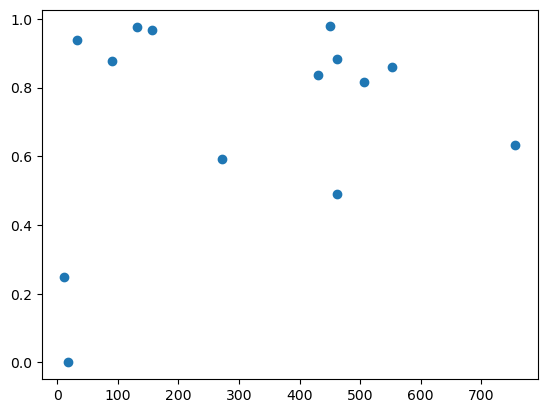

In [9]:
plt.scatter(df_en.total, df_en.accuracy)

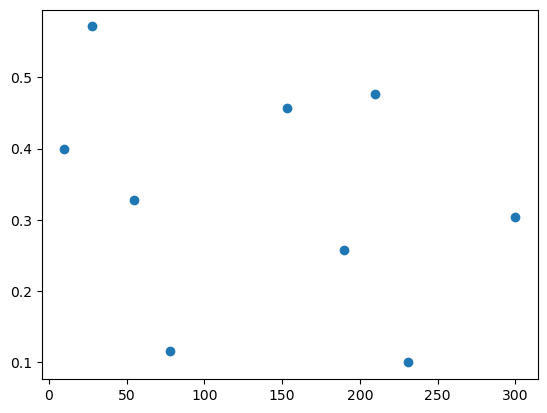

In [10]:
plt.scatter(df.total, df.accuracy)

# Webcorpus 2.0: gluten-free and vanila

In [11]:
def aggregate_score(model):
    df = get_analogy_scores(model, questions)
    df.drop(index=['capital-world', 'capital-common-countries'], inplace=True)
    # capital-world is disregarded because large OOV makes this relation instabile
    # [~df.index.str.startswith('gram')]
    return df.accuracy.mean()

In [12]:
embed_dir = '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0'

In [13]:
file_patterns = ['2017_2018_2956', '2017_2018_295', '2017_2018_29', 'wiki', '2017_2018_2', '2017_2018']#, '201', ''

In [14]:
def get_accuracy_by_size():
    for file_pattern in file_patterns:
        for deglutinate_ in ['vanila', 'deglut', 'deglutAllSuffSepd']:
            try:
                model = KeyedVectors.load(f'{embed_dir}/sgns-300-{file_pattern}-{deglutinate_}.gensim', mmap='r')
            except FileNotFoundError:
                continue
            record = {
                'files': f'{file_pattern}*',
                'deglut' : deglutinate_,
                'sentence': model.corpus_count, 
                'token': model.corpus_total_words, 
                'type': len(model.wv.key_to_index)}
            df = get_analogy_scores(model.wv, questions)
            for relation in ['common-countries', 'world']:
                record[f'capital-{relation} correct'] = df.loc[f'capital-{relation}', 'correct']
                record[f'capital-{relation} total'] = df.loc[f'capital-{relation}', 'total']
            df.drop(index=['capital-world', 'capital-common-countries'], inplace=True)
            record['accuracy'] = df.accuracy.mean()
            print((record['files'], record['deglut']))
            yield record

In [15]:
records = get_accuracy_by_size()

In [16]:
df_ = pd.DataFrame(records)

('2017_2018_2956*', 'vanila')
('2017_2018_2956*', 'deglut')
('2017_2018_2956*', 'deglutAllSuffSepd')
('2017_2018_295*', 'vanila')
('2017_2018_295*', 'deglut')
('2017_2018_295*', 'deglutAllSuffSepd')
('2017_2018_29*', 'vanila')
('2017_2018_29*', 'deglut')
('2017_2018_29*', 'deglutAllSuffSepd')
('wiki*', 'vanila')
('wiki*', 'deglut')
('wiki*', 'deglutAllSuffSepd')
('2017_2018_2*', 'vanila')
('2017_2018_2*', 'deglut')
('2017_2018_2*', 'deglutAllSuffSepd')
('2017_2018*', 'vanila')
('2017_2018*', 'deglut')
('2017_2018*', 'deglutAllSuffSepd')


In [17]:
for relation in ['common-countries', 'world']:
    df_[f'capital-{relation} accuracy'] = df_[f'capital-{relation} correct'] / df_[f'capital-{relation} total']

In [18]:
df = df_.drop(columns=['deglut', 'accuracy']).groupby('files').max()
df = df.join(pd.pivot_table(df_, values='accuracy', index='files', columns='deglut'), rsuffix='_')

In [19]:
for relation in ['common-countries', 'world']:
    df = df.join(pd.pivot_table(df_, values=f'capital-{relation} accuracy', index='files', columns='deglut'), 
                 rsuffix=f'_capital-{relation}')
    df.drop(columns=[f'capital-{relation} correct', f'capital-{relation} total'])

In [20]:
df.sort_values('sentence', inplace=True)

In [21]:
df

,sentence,token,type,capital-common-countries correct,capital-common-countries total,capital-world correct,capital-world total,capital-common-countries accuracy,capital-world accuracy,deglut,deglutAllSuffSepd,vanila,deglut_capital-common-countries,deglutAllSuffSepd_capital-common-countries,vanila_capital-common-countries,deglut_capital-world,deglutAllSuffSepd_capital-world,vanila_capital-world
files,,,,,,,,,,,,,,,,,,
2017_2018_2956*,66798,1246317,9388,0,1,1,15,0.000000,0.066667,0.033333,0.016667,0.000650,0.000000,0.000000,NaN,0.066667,0.000000,0.000000
2017_2018_295*,879317,23261396,149981,0,1,0,6,0.000000,0.000000,0.048498,0.050489,0.073301,0.000000,0.000000,NaN,0.000000,0.000000,NaN
wiki*,11798744,200357761,920965,39,78,151,406,0.555556,0.415789,0.301049,0.332903,0.461793,0.500000,0.461538,0.555556,0.337438,0.371921,0.415789
2017_2018_29*,12058626,310703112,1028343,8,15,22,66,1.000000,1.000000,0.335747,0.317981,0.469687,0.533333,0.266667,1.000000,0.333333,0.303030,1.000000
2017_2018_2*,133832368,3395599678,4730753,11,15,33,66,0.733333,0.500000,0.505566,0.519638,0.579354,0.266667,0.733333,NaN,0.378788,0.500000,0.000000
2017_2018*,511812157,13144806360,11400728,8,15,34,66,1.000000,1.000000,0.430760,0.467365,0.618774,0.533333,0.400000,1.000000,0.515152,0.484848,1.000000


In [22]:
def thousand(int_):
    return f'{int_:,}'

In [23]:
df_formed = df.apply({col: thousand if col in ['sentence', 'token', 'type'] else lambda x: x 
                             for col in df.columns})
#print(df_formed[['sentence', 'token', 'type', 'vanila', 'deglutAllSuffSepd', 'deglut']].style.to_latex())
df_formed[['sentence', 'token', 'type', 'vanila', 'deglutAllSuffSepd', 'deglut']]

,sentence,token,type,vanila,deglutAllSuffSepd,deglut
files,,,,,,
2017_2018_2956*,"66,798","1,246,317","9,388",0.000650,0.016667,0.033333
2017_2018_295*,"879,317","23,261,396","149,981",0.073301,0.050489,0.048498
wiki*,"11,798,744","200,357,761","920,965",0.461793,0.332903,0.301049
2017_2018_29*,"12,058,626","310,703,112","1,028,343",0.469687,0.317981,0.335747
2017_2018_2*,"133,832,368","3,395,599,678","4,730,753",0.579354,0.519638,0.505566
2017_2018*,"511,812,157","13,144,806,360","11,400,728",0.618774,0.467365,0.430760


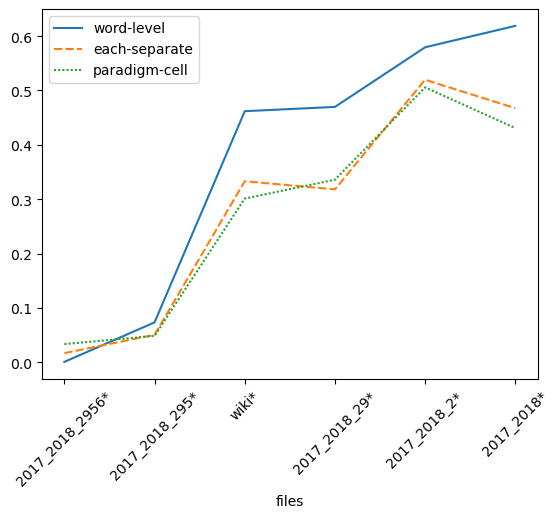

In [44]:
df.rename(columns={'vanila': 'word-level', 
                   'deglutAllSuffSepd': 'each-separate',
                   'deglut': 'paradigm-cell'}, inplace=True)
sns.lineplot(df[['word-level', 'each-separate', 'paradigm-cell']])
_ = plt.xticks(rotation=45)
plt.savefig('gluten-free-analogy.png', bbox_inches="tight")

In [ ]:
_ = plt.xticks(rotation=45)
plt.savefig('gluten-free-analogy.png')

In [23]:
df[['deglut_capital-common-countries',
       'deglutAllSuffSepd_capital-common-countries',
       'vanila_capital-common-countries']].plot()
_ = plt.xticks(rotation=90)


KeyError: "None of [Index(['deglut_capital-common-countries',\n       'deglutAllSuffSepd_capital-common-countries',\n       'vanila_capital-common-countries'],\n      dtype='object')] are in the [columns]"

# Investigating the strange results

In [ ]:
def plot_accur_of_two_embeds(accuracies_vanila, accuracies_deglut, lname='vanila', rname='deglut', 
                             column='accuracy'):
    accuracies = accuracies_vanila.join(accuracies_deglut, rsuffix=f'-{rname}')
    plt.scatter(accuracies[f'{column}'], accuracies[f'{column}-{rname}'])
    plt.xlabel(lname)
    plt.ylabel(rname)
    for relation, stats in accuracies.iterrows():
        plt.annotate(relation, xy=(stats[f'{column}'], stats[f'{column}-{rname}']), rotation=45)

In [ ]:
def get_analogy_scores_wrapper(filen_suff, deglut):
    vecs = KeyedVectors.load(f'{embed_dir}/sgns-300-{filen_suff}-{deglut}.gensim')
    return get_analogy_scores(vecs.wv, questions)

## Two kinds of deglut

### Greatest difference

In [ ]:
nemeskey = get_analogy_scores_wrapper('2017_2018_2', 'deglutAllSuffSepd')

In [ ]:
twopart = get_analogy_scores_wrapper('2017_2018_2', 'deglut')

In [ ]:
plot_accur_of_two_embeds(nemeskey, twopart, lname='nemeskey', rname='twopart', column='correct')

## Larger corpus is worse

## deglut 13G: `capital-common-countries` is worse in the larger corpus

### Nemeskey-style

In [ ]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018_2-deglutAllSuffSepd.gensim')
accur_3G = get_analogy_scores(vecs.wv, questions)

In [ ]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglutAllSuffSepd.gensim')
accur_13G = get_analogy_scores(vecs.wv, questions)

In [ ]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large')

In [ ]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large', column='correct')
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
accur_3G.loc['capital-common-countries']

In [ ]:
accur_13G.loc['capital-common-countries']

### two-part

In [ ]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018_2-deglut.gensim')
accur_3G = get_analogy_scores(vecs.wv, questions)

In [ ]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglut.gensim')
accur_13G = get_analogy_scores(vecs.wv, questions)

In [ ]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large')

In [ ]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large', column='correct')
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
accur_3G.loc['capital-common-countries']

In [ ]:
accur_13G.loc['capital-common-countries']

## Wiki vs similar-sized webcorpus

In [ ]:
wiki_vanl = get_analogy_scores_wrapper('wiki', 'vanila')
wiki_dg_nemeskey = get_analogy_scores_wrapper('wiki', 'deglutAllSuffSepd')
wiki_dg_twopart = get_analogy_scores_wrapper('wiki', 'deglut')
webcorp_vanl = get_analogy_scores_wrapper('2017_2018_29', 'vanila')
webcorp_dg_nemeskey = get_analogy_scores_wrapper('2017_2018_29', 'deglutAllSuffSepd')
webcorp_dg_twopart = get_analogy_scores_wrapper('2017_2018_29', 'deglut')

### vanila

In [ ]:
plot_accur_of_two_embeds(wiki_vanl, webcorp_vanl, lname='wiki', rname='web')

In [ ]:
plot_accur_of_two_embeds(wiki_vanl, webcorp_vanl, lname='wiki', rname='web', column='correct')

In [ ]:
wiki_vanl.loc['capital-common-countries']

In [ ]:
webcorp_vanl.loc['capital-common-countries']

### two-part

In [ ]:
plot_accur_of_two_embeds(wiki_dg_twopart, webcorp_dg_twopart, lname='wiki', rname='web')

In [ ]:
plot_accur_of_two_embeds(wiki_dg_twopart, webcorp_dg_twopart, lname='wiki', rname='web', column='correct')

### Nemeskey-style

In [ ]:
plot_accur_of_two_embeds(wiki_dg_nemeskey, webcorp_dg_nemeskey, lname='wiki', rname='web')

In [ ]:
plot_accur_of_two_embeds(wiki_dg_nemeskey, webcorp_dg_nemeskey, lname='wiki', rname='web', column='correct')

# Sanity check of the gluten-free embed

In [ ]:
vectors_vanila = KeyedVectors.load(
    '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-vanila.gensim').wv

In [ ]:
vectors_vanila.most_similar('menekít')

In [ ]:
accuracies_vanila = get_analogy_scores(vectors_vanila, questions)

In [ ]:
vectors_deglut = KeyedVectors.load(
    '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglut.gensim').wv

In [ ]:
vectors_deglut.most_similar('menekít')

In [ ]:
accuracies_deglut = get_analogy_scores(vectors_deglut, questions)